## Etudiante: GIANG Phuong-Thu, Cécile (3530406)

# TME sur la classification de lettres manuscrites
## Format des données
Nous travaillerons sur des lettres manuscrites.
Les données sont fournies au format pickle (le standard de sérialisation python, particulièrement convivial). Pour les charger : 

In [1]:
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt

with open('ressources/lettres.pkl', 'rb') as f:
    data = pkl.load(f, encoding='latin1') 
X = np.array(data.get('letters')) # récupération des données sur les lettres
Y = np.array(data.get('labels')) # récupération des étiquettes associées 

Les données sont dans un format original: une lettre est en fait une série d'angles (exprimés en degrés). Un exemple: 

In [2]:
X[0]

array([ 36.214493, 347.719116, 322.088898, 312.230957, 314.851013,
       315.487213, 313.556702, 326.534973, 141.288971, 167.606689,
       199.321594, 217.911087, 226.443298, 235.002472, 252.354492,
       270.045654, 291.665161, 350.934723,  17.892815,  20.281025,
        28.207161,  43.883423,  53.459026])

Lors de l'acquisition, un stylo intelligent a pris des mesures régulièrement dans le temps: chaque période correspond à un segment de droite et le stylo a calculé l'angle entre deux segments consécutifs... C'est l'information qui vous est fournie.

Pour afficher une lettre, il faut reconstruire la trajectoire enregistrée... C'est ce que fait la méthode ci-dessous: 

In [3]:
# affichage d'une lettre
def tracerLettre(let):
    a = -let*np.pi/180; # conversion en rad
    coord = np.array([[0, 0]]); # point initial
    for i in range(len(a)):
        x = np.array([[1, 0]]);
        rot = np.array([[np.cos(a[i]), -np.sin(a[i])],[ np.sin(a[i]),np.cos(a[i])]])
        xr = x.dot(rot) # application de la rotation
        coord = np.vstack((coord,xr+coord[-1,:]))
    plt.figure()
    plt.plot(coord[:,0],coord[:,1])
    #plt.savefig("exlettre.png")
    return

a


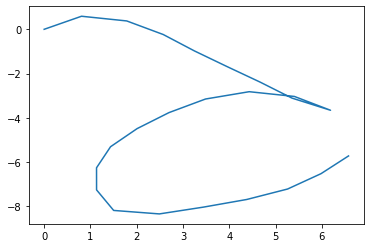

In [4]:
# il s'agit d'un 'a'
tracerLettre(X[0])
print(Y[0]) # vérification de l'étiquette

## A. Apprentissage d'un modèle CM (max de vraisemblance)
### A1. Discrétisation

**1 état = 1 angle**

Il est nécessaire de regrouper les angles en un nombre fini d'états (par exemple 20)
- définir un `intervalle = 360 / n_etats` (18° si on choisit 20 états)
- discrétiser tous les signaux à l'aide de la formule `np.floor(x / intervalle)`
    - si n_etats = 20 alors [0, 18[ => 0, [18, 36[ => 1, etc...

Donner le code de la méthode `discretise(x, d)` qui prend la base des signaux et retourne une base de signaux discrétisés.

In [24]:
def discretise(x, d):
    """ Etant donné un ensemble de signaux x, retourne la base x discrétisée, i.e. retourne x sur la base de d états, 
        chaque état correspondant à un intervalle [x, x + intervalle[ avec intervalle = 360/d.
        @param x: float array x array, base des signaux à discrétiser
        @param d: int, nombre d'états considérés
        @return x_d: np.array x array, base des signaux x discrétisés
    """
    # -- Calcul de la taille d'un intervalle
    intervalle = 360 / d
    
    # -- Initialisation de la base x_d des signaux discrétisés
    x_d = np.empty_like(x)
    
    # -- Calcul de x_d
    for i in range(len(x)):
        x_d[i] = np.floor(x[i] / intervalle)
        
    return x_d

**VALIDATION :** code du premier signal avec une discrétisation sur 3 états:
```python
array([ 0.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  1.,  1.,  1.,  1., 1., 1., 2., 2.,  2.,
       2.,  0.,  0.,  0.,  0.,  0.])
```

**Vérification des résultats:**

In [27]:
discretise(X[0], 3)

array([0., 2., 2., 2., 2., 2., 2., 2., 1., 1., 1., 1., 1., 1., 2., 2., 2.,
       2., 0., 0., 0., 0., 0.])

Nous obtenons bien le résultat attendu.

### A2. Regrouper les indices des signaux par classe (pour faciliter l'apprentissage)

In [28]:
def groupByLabel(y):
    index = []
    for i in np.unique(y): # pour toutes les classes
        ind, = np.where(y == i)
        index.append(ind)
    return index

Cette méthode produit simplement une structure type:
```python
[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 array([11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]),
 array([22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]),
 array([33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43]),
 array([44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54]),
 array([55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65]),
 ...
```
Chaque ligne regroupe les indices de signaux correspondant à une classe. Il y a donc 11 exemples de 'a'.

**Vérification avec la donnée Y des étiquettes:**

In [43]:
groupByLabel(Y)

[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64),
 array([11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21], dtype=int64),
 array([22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32], dtype=int64),
 array([33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43], dtype=int64),
 array([44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54], dtype=int64),
 array([55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65], dtype=int64),
 array([66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76], dtype=int64),
 array([77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87], dtype=int64),
 array([88, 89, 90, 91, 92, 93, 94, 95, 96, 97], dtype=int64),
 array([ 98,  99, 100, 101, 102, 103, 104, 105, 106, 107], dtype=int64),
 array([108, 109, 110, 111, 112, 113, 114, 115, 116, 117], dtype=int64),
 array([118, 119, 120, 121, 122, 123, 124, 125, 126, 127], dtype=int64),
 array([128, 129, 130, 131, 132, 133, 134, 135, 136, 137], dtype=int64),
 array([138, 139, 140, 141, 142, 143, 144, 145, 146, 147], dtype=int64),
 array([148, 149, 150, 151, 152, 153

### A3. Apprendre les modèles CM

Soit {$X_C$} la base de signaux discrétisés correspondant à une classe {$C$} et {$d$} le nombre d'états. Donner le code de la fonction `learnMarkovModel(Xc, d)` qui retourne un tuple contenant Pi et A.

Rappel:
- Initialisation de 
```python
 A = np.zeros((d, d))
 Pi = np.zeros(d)```
- Parcours de tous les signaux et incréments de A et Pi
- Normalisation (un peu réfléchie pour éviter les divisions par 0)
```python
A = A / np.maximum(A.sum(1).reshape(d, 1), 1) # normalisation
Pi = Pi / Pi.sum()```

**Note** : la solution proposée pour gérer le cas des lignes entièrement à 0 est naïve et n'est pas totalement satisfaisante. Comprendre pourquoi. On proposera une solution améliorée plus loin dans le TME. 

In [36]:
def learnMarkovModel(Xc, d):
    """ Etant donné Xc un signal discrétisé correspondant à une classe C et d le nombre d'états, retourne
        un tuple contenant Pi la liste des probabilités initiales de chaque état et A la matrice de transitions.
        @param Xc: np.array, signal discrétisé correspondant à une classe C
        @param d: int, nombre d'états
        @return Pi: float array, liste des probabilités initiales pour chaque état (distribution initiale)
        @return A: float array x array, matrice de transition
    """
    # -- Initialisation de A et Pi
    A = np.zeros((d, d))
    Pi = np.zeros(d)
    
    # -- Parcours de tous les signaux et incrémentation de A et Pi
    
    for x in Xc:
        for k in range(len(x)-1):
            i = int( x[k] )
            j = int( x[k+1] )
            A[i][j] += 1
        
        Pi[ int(x[0]) ] += 1
    
    # -- Normalisation
    A = A / np.maximum(A.sum(1).reshape(d, 1), 1)
    Pi = Pi / Pi.sum()
    
    return Pi, A

**Validation :** premier modèle avec une discrétisation sur 3 états :
```python
(array([ 0.36363636,  0.        ,  0.63636364]),
 array([[ 0.84444444,  0.06666667,  0.08888889],
       [ 0.        ,  0.83333333,  0.16666667],
       [ 0.11382114,  0.06504065,  0.82113821]]))
```

**Vérification:** Testons pour le premier modèle (la lettre `a`) avec une discrétisation sur 3 états

In [47]:
# -- d le nombre d'états
d = 3

# -- Xc la base de signaux discrétisés
Xd = discretise(X, d)

# -- Regroupement des signaux par classe
index = groupByLabel(Y)

# -- Apprentissage Markov
learnMarkovModel(Xd[index[0]], d)

(array([0.36363636, 0.        , 0.63636364]),
 array([[0.84444444, 0.06666667, 0.08888889],
        [0.        , 0.83333333, 0.16666667],
        [0.11382114, 0.06504065, 0.82113821]]))

### A4. Stocker les modèles dans une liste

Pour un usage ultérieur plus facile, on utilise le code suivant :

In [48]:
d = 20                   # paramètre de discrétisation
Xd = discretise(X, d)    # application de la discrétisation
index = groupByLabel(Y)  # groupement des signaux par classe
models = []
for cl in range(len(np.unique(Y))): # parcours de toutes les classes et optimisation des modèles
    models.append(learnMarkovModel(Xd[index[cl]], d))

### A5. Distribution stationnaire

La distribution stationnaire $\mu$, pour un système ergodique, correspond à:

- la distribution des états observés dans l'ensemble des données
- la distribution obtenu après un grand nombre de passage dans $A$ à partir de n'importe quelle distribution ou état d'origine (une matrice de transition ergodique va nous permettre de converger)
- la solution de l'équation de stabilité: $\mu = \mu A$

Dans le cas de la lettre 'a' et d'une discrétisation en 3 états, calculer la distribution stationnaire par les deux première méthode et vérifier que vous obtenez des résultats similaires.

**Note:** pour la marche aléatoire, vous construirez une boucle sur 100 iérations (borne sup) et vous sortirez dès que la somme des écarts (en absolu) entre $\mu_t$ et $\mu_{t+1}$ est inférieure à $10^{-3}$. Vous vérifierez ensuite que le système converge quelque soit l'état de départ (3 appel àla fonction) ou avec une initialisation aléatoire.

In [78]:
# -- Calcul de Pi et A pour la lettre 'a' et une discrétisation en 3 états

d = 3
Xd = discretise(X, d)
index = groupByLabel(Y)

Pi, A = learnMarkovModel(Xd[index[0]], d)

# --- Calcul de de la distribution stationnaire mu

def distribution_stationnaire(Pi, A, nb_ite=100, mu_t=np.copy(Pi)):
    """ Calcul de la distribution stationnaire mu à partir des probabilités de départ Pi et de la matrice de transition A.
        @param Pi: float array, probabilités de départ pour chaque état
        @param A: float array x array, matrice de transition
        @return mu_2: float array, distribution stationnaire
    """
    # -- Initialisation de mu_0 (mu_t) et mu_t (mu_{t+1})
    mu_0 = np.zeros(len(Pi))
    
    i = 0
    
    while i < nb_ite and np.sum(np.abs(mu_t - mu_0)) > 0.001 :
        mu_0 = mu_t
        mu_t = np.dot(mu_t, A)
        i += 1
    
    print("Nombre d'itérations avant convergence: ", i)
    
    return mu_t

**Test avec pour initialisation: `mu_t = Pi`:**

In [79]:
distribution_stationnaire(Pi, A)

Nombre d'itérations avant convergence:  22


array([0.30477844, 0.28202157, 0.41319999])

**Tests avec initialisations aléatoires de `mu_t`:**

In [83]:
### ------- Premier test aléatoire

print('------- Test aléatoire 1 ------- \n\n')

mu_1 = np.random.rand(len(Pi))
print('mu = ', mu_1)
print('\nDistribution stationnaire: \n', distribution_stationnaire(Pi, A, mu_t = mu_1))


### ------- Deuxième test aléatoire

print('\n\n------- Test aléatoire 2 ------- \n\n')

mu_2 = np.random.rand(len(Pi))
print('mu = ', mu_2)
print('\nDistribution stationnaire: \n', distribution_stationnaire(Pi, A, mu_t = mu_2))

------- Test aléatoire 1 ------- 


mu =  [0.36911035 0.00800456 0.7299495 ]
Nombre d'itérations avant convergence:  23

Distribution stationnaire: 
 [0.33693066 0.31244145 0.4576923 ]


------- Test aléatoire 2 ------- 


mu =  [0.14483727 0.43758563 0.3863699 ]
Nombre d'itérations avant convergence:  21

Distribution stationnaire: 
 [0.29214462 0.27459967 0.4020485 ]


**Observations:**

Nous remarquons que même en initialisant les probabilités initiales `Pi` de manière aléatoire, nous convergeons vers une distribution stationnaire assez proche de la distribution obtenue avec `mu = Pi`.

Nous retrouvons ainsi une propriété d'une chaîne de Markov ergodique: une chaîne de Markov est ergodique si `Pi_n` converge, indépendamment de `Pi_0` (la distribution initiale).

##  B. Test (affectation dans les classes sur critère MV)
### B1. (log)Probabilité d'une séquence dans un modèle

Donner le code de la méthode `probaSequence(s,Pi,A)` qui retourne la log-probabilité d'une séquence `s` dans le modèle {$\lambda=\{Pi,A\}$} 

In [106]:
def probaSequence(s, Pi, A):
    """ Retourne la log-probabilité d'une séquence s dans le modèle lambda = {Pi, A}.
        @param s: float array, séquence
        @param Pi: float array, probabilités initiales de chaque état
        @param A: float array x array, matrice de transition
        @return p: float array, la log-probabilité de la séquence s dans le modèle {Pi, A}
    """
    p = Pi[int(s[0])]
    
    for i in range(len(s)-1):
        p *= A[ int(s[i]), int(s[i+1]) ]
        
    return np.log(p)

**VALIDATION :** probabilité du premier signal dans les 26 modèles avec une discrétisation sur 3 états :
```python
array([-13.491086  ,         -inf,         -inf,         -inf,
               -inf,         -inf,         -inf,         -inf,
               -inf,         -inf,         -inf,         -inf,
               -inf,         -inf,         -inf,         -inf,
               -inf,         -inf,         -inf,         -inf,
               -inf,         -inf,         -inf,         -inf,
               -inf, -12.48285678])
```

- Ce signal est-il bien classé ?
- D'où viennent tous les `-inf` ? 

**Vérification pour le 1er signal avec une discrétisation sur 3 états:**

In [112]:
# -- Calcul des log-probabilités pour le 1er signal et une discrétisation en 3 états

d=3

# -- Liste des log-probabilités
log_probas = []

for Pi, A in models:
    log_probas.append(probaSequence(discretise(X,d)[0], Pi, A))

print(np.array(log_probas))

[-13.491086           -inf         -inf         -inf         -inf
         -inf         -inf         -inf         -inf         -inf
         -inf         -inf         -inf         -inf         -inf
         -inf         -inf         -inf         -inf         -inf
         -inf         -inf         -inf         -inf         -inf
 -12.48285678]


<ipython-input-106-22acc3392aed>:13: RuntimeWarning: divide by zero encountered in log
  return np.log(p)


Par maximum de vraisemblance, la lettre 'a' est classée dans la classe des lettres ' z '


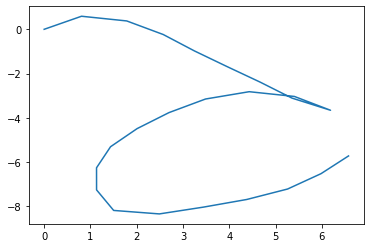

In [115]:
# -- Affichage de la lettre correspondant au 1er signal

tracerLettre(X[0])

# -- Affichage de la lettre obtenue par maximum de vraisemblance:

alphabet = {0:'a', 1:'b', 2:'c', 3:'d', 4:'e', 5:'f', 6:'g', 7:'h', 8:'i', 9:'j', 10:'k', 11:'l', 12:'m', 
            13:'n', 14:'o', 15:'p', 16:'q', 17:'r', 18:'s', 19:'t', 20:'u', 21:'v', 22:'w', 23:'x', 24:'y', 25:'z'}

print('Par maximum de vraisemblance, la lettre \'a\' est classée dans la classe des lettres \'', alphabet[np.argmax(log_probas)] ,'\'')

**Observations:**

Nous obtenons bien les log-probabilités obtenues. Cependant, le 1er signal, qui correspond à la lettre `a` d'après l'affichage, est classé comme lettre `z` par maximum de vraisemblance...
On obtient donc une **mauvaise classification**.

### B2. Application de la méthode précédente pour tous les signaux et tous les modèles de lettres

L'application se fait en une ligne de code si vous avez respecté les spécifications précédentes : 

In [117]:
proba = np.array([[probaSequence(Xd[i], models[cl][0], models[cl][1]) for i in range(len(Xd))]
                  for cl in range(len(np.unique(Y)))])

print(proba)

[[-13.491086   -10.38325849 -10.70816592 ... -18.3696345  -13.74527613
  -20.59178751]
 [        -inf         -inf         -inf ...         -inf         -inf
          -inf]
 [        -inf         -inf         -inf ...         -inf         -inf
          -inf]
 ...
 [        -inf         -inf         -inf ...         -inf         -inf
          -inf]
 [        -inf         -inf         -inf ...         -inf         -inf
          -inf]
 [-12.48285678         -inf         -inf ... -14.76870842 -11.9972425
  -17.91075189]]


<ipython-input-106-22acc3392aed>:13: RuntimeWarning: divide by zero encountered in log
  return np.log(p)


### B3. Evaluation des performances

Pour l'évaluation, nous proposons l'approche suivante: 

In [ ]:
# calcul d'une version numérique des Y :
Ynum = np.zeros(Y.shape)
for num, char in enumerate(np.unique(Y)):
    Ynum[Y == char] = num
    
# Calcul de la classe la plus probable :
pred = proba.argmax(0) # max colonne par colonne

# Calcul d'un pourcentage de bonne classification :
np.where(pred != Ynum, 0.,1.).mean()

**INDICE DE PERFORMANCE :** 91% de bonne classification avec 20 états, 69% avec 3 états

**Vérification du taux de classification avec 3 états:**

In [127]:
# calcul d'une version numérique des Y :
Ynum = np.zeros(Y.shape)
for num, char in enumerate(np.unique(Y)):
    Ynum[Y == char] = num
    
# Calcul de la classe la plus probable :
pred = proba.argmax(0) # max colonne par colonne

# Calcul d'un pourcentage de bonne classification :
np.where(pred != Ynum, 0.,1.).mean()

0.6902985074626866

**Vérification du taux de classification avec 20 états:**

In [128]:
# --- Discrétisation en 20 états

d = 20                   # paramètre de discrétisation
Xd = discretise(X, d)    # application de la discrétisation
index = groupByLabel(Y)  # groupement des signaux par classe

models = []
for cl in range(len(np.unique(Y))): # parcours de toutes les classes et optimisation des modèles
    models.append(learnMarkovModel(Xd[index[cl]], d))

proba = np.array([[probaSequence(Xd[i], models[cl][0], models[cl][1]) for i in range(len(Xd))]
                  for cl in range(len(np.unique(Y)))])

# calcul d'une version numérique des Y :
Ynum = np.zeros(Y.shape)
for num, char in enumerate(np.unique(Y)):
    Ynum[Y == char] = num
    
# Calcul de la classe la plus probable :
pred = proba.argmax(0) # max colonne par colonne

# Calcul d'un pourcentage de bonne classification :
np.where(pred != Ynum, 0.,1.).mean()

<ipython-input-106-22acc3392aed>:13: RuntimeWarning: divide by zero encountered in log
  return np.log(p)


0.914179104477612

**Observations:**

Nous obtenons bien les taux de classification attendus, soit environ 69% de bonne classifcation avec 3 états, et environ 91% de bonne classification avec 20 états.

## C. Biais d'évaluation, notion de sur-apprentissage

Dans le protocole précédent, nous avons triché:
- les données servent d'abord à apprendre les modèles...
- puis nous nous servons des mêmes données pour tester les modèles ! Les performances sont forcément bonnes ! 

Afin de palier le problème, nous allons diviser en deux la base de données: une partie servira à l'apprentissage des modèles, l'autre à leur évaluation. Pour effectuer la division, nous fournissons le code suivant: 

In [129]:
# separation app/test, pc=ratio de points en apprentissage
def separeTrainTest(y, pc):
    indTrain = []
    indTest = []
    for i in np.unique(y): # pour toutes les classes
        ind, = np.where(y == i)
        n = len(ind)
        indTrain.append(ind[np.random.permutation(n)][:int(np.floor(pc * n))])
        indTest.append(np.setdiff1d(ind, indTrain[-1]))
    return indTrain, indTest

# exemple d'utilisation
itrain, itest = separeTrainTest(Y, 0.8)

dans `itrain`, nous obtenons les indices des signaux qui doivent servir en apprentissage pour chaque classe :

In [130]:
itrain

[array([ 2,  9,  4,  1,  0,  6, 10,  7], dtype=int64),
 array([12, 21, 19, 16, 20, 18, 15, 17], dtype=int64),
 array([32, 28, 25, 31, 22, 30, 24, 27], dtype=int64),
 array([36, 35, 33, 41, 37, 40, 42, 34], dtype=int64),
 array([46, 53, 52, 51, 49, 48, 54, 47], dtype=int64),
 array([61, 63, 64, 65, 60, 55, 58, 56], dtype=int64),
 array([71, 70, 74, 75, 73, 68, 66, 69], dtype=int64),
 array([83, 85, 80, 84, 79, 81, 82, 87], dtype=int64),
 array([97, 92, 96, 95, 89, 88, 90, 91], dtype=int64),
 array([ 98, 104,  99, 103, 105, 100, 102, 101], dtype=int64),
 array([112, 113, 111, 115, 117, 109, 108, 114], dtype=int64),
 array([122, 119, 125, 127, 120, 118, 121, 124], dtype=int64),
 array([131, 132, 129, 133, 136, 128, 135, 137], dtype=int64),
 array([140, 144, 141, 146, 147, 138, 142, 139], dtype=int64),
 array([156, 149, 151, 148, 152, 150, 157, 155], dtype=int64),
 array([165, 160, 162, 166, 158, 161, 167, 163], dtype=int64),
 array([171, 177, 172, 175, 168, 173, 174, 170], dtype=int64),
 

**Note :** pour faciliter l'évaluation des modèles, vous aurez besoin de re-fusionner tous les indices d'apprentissage et de test. Cela se fait avec les lignes de code suivantes : 

In [132]:
# -- Liste des indices d'apprentissage ia
ia = []
for i in itrain:
    ia += i.tolist()    
    
# -- Liste des indices de test it
it = []
for i in itest:
    it += i.tolist()

**Note 2 :** Du fait de la permutation aléatoire, les résultats vont bouger (un peu) à chaque execution du programme. 

### C1. Questions importantes
- Ré-utiliser les fonctions précédemment définies pour apprendre des modèles et les évaluer sans biais.
- Calculer et analyser les résultats obtenus en apprentissage et en test
- Etudier l'évolution des performances en fonction de la discrétisation

In [150]:
# -- Séparation des données: 80% sur train et 20% sur test
itrain, itest = separeTrainTest(Y, 0.8)


# -- Tableaux d'indices pour entrainement et pour test
ia = []
for i in itrain:
    ia += i.tolist()
it = []
for i in itest:
    it += i.tolist()

    
# -- Construction des ensembles de données d'entraînement et de test en fonction des indices calculés ci-dessus
X_train = np.array([X[i] for i in ia]) 
X_test = np.array([X[i] for i in it])

Y_train = np.array([Y[i] for i in ia])
Y_test = np.array([Y[i] for i in it])



# ----------------- CALCUL DU TAUX DE BONNE CLASSIFICATION POUR UN NOMBRE D'ETATS d VARIANT DE 3 A 20 -----------------

taux_bonne_classification = []

for d in range(3,21):
    
    # application de la discrétisation
    Xd_train = discretise(X_train, d)
    Xd_test = discretise(X_test,d)

    # groupement des signaux par classe
    index_train = groupByLabel(Y_train)
    index_test = groupByLabel(Y_test)

    models = []
    for cl in range(len(np.unique(Y_train))): # parcours de toutes les classes et optimisation des modèles
        models.append(learnMarkovModel(Xd_train[index_train[cl]], d))
        

    # calcul d'une version numérique des Y :
    Ynum = np.zeros(Y_test.shape)
    for num, char in enumerate(np.unique(Y_test)):
        Ynum[Y_test == char] = num

        
    proba = np.array([[probaSequence(Xd_test[i], models[cl][0], models[cl][1]) for i in range(len(Xd_test))]
                      for cl in range(len(np.unique(Y_test)))])
    
    
    # Calcul de la classe la plus probable :
    pred = proba.argmax(0) # max colonne par colonne

    # Calcul d'un pourcentage de bonne classification :
    taux_bonne_classification.append(np.where(pred != Ynum, 0.,1.).mean())

<ipython-input-106-22acc3392aed>:13: RuntimeWarning: divide by zero encountered in log
  return np.log(p)


**Affichage des taux de bonne classification pour un nombre d'état `d` variant de 3 à 20:**

In [151]:
print('Taux de bonne classification...')
for d in range(3,21):
    print('\t... pour d = ', d, ' : ', taux_bonne_classification[d-3])

Taux de bonne classification...
	... pour d =  3  :  0.6166666666666667
	... pour d =  4  :  0.6333333333333333
	... pour d =  5  :  0.75
	... pour d =  6  :  0.5833333333333334
	... pour d =  7  :  0.5333333333333333
	... pour d =  8  :  0.6
	... pour d =  9  :  0.5166666666666667
	... pour d =  10  :  0.6166666666666667
	... pour d =  11  :  0.5833333333333334
	... pour d =  12  :  0.4166666666666667
	... pour d =  13  :  0.38333333333333336
	... pour d =  14  :  0.3333333333333333
	... pour d =  15  :  0.36666666666666664
	... pour d =  16  :  0.43333333333333335
	... pour d =  17  :  0.3
	... pour d =  18  :  0.31666666666666665
	... pour d =  19  :  0.3333333333333333
	... pour d =  20  :  0.25


**Observations:**

Le taux de bonne classification des lettres de `X_test` diminue lorsque la taille de discrétisation `d` (le nombre d'états) augmente. Cela s'explique aisément: lorsque d augmente, la taille de notre matrice de transition augmente (taille n²), et comme nous n'avons pas assez de données, nous aurons des difficultés à trouver plusieurs cas pour chaque transition d'états (représentée par un élement de la matrice).

Ainsi, les probabilités contenues dans la matrice de transition sont très petites, ce qui affecte grandement le résulat.

### C2. Lutter contre le sur-apprentissage
Cette base de données met en lumière le phénomène de sur-apprentissage : il y a peu de données et dès que le nombre d'états augmente, il y a trop peu d'exemple pour estimer correctement les matrices {$A, \pi$}. De nombreuses cases sont donc à 0, voire des lignes entières (d'où la sécurisation du code pour la normalisation des matrices stochastiques).

Ces 0 sont particulièrement discriminants: considérant la classe {$c$}, ils permettent d'éliminer de cette classe tout signal présentant cette caractéristique. Cette règle est trop forte compte tenu de la taille de la base d'apprentissage. Nous proposons une astuce pour palier cette faiblesse : lors du comptage, initialiser les matrices {$A, \pi$} avec ones au lieu de zeros . On fait semblant d'avoir observer une transition de chaque type avant même le début du comptage.

Comparer les performances en test.

In [152]:
def learnMarkovModel_ones(Xc, d):
    """ Etant donné Xc un signal discrétisé correspondant à une classe C et d le nombre d'états, retourne
        un tuple contenant Pi la liste des probabilités initiales de chaque état et A la matrice de transitions.
        Cette fois-ci, lors du comptage, nous initialisons les matrices {A, Pi} avec ones au lieu de zeros.
        @param Xc: np.array, signal discrétisé correspondant à une classe C
        @param d: int, nombre d'états
        @return Pi: float array, liste des probabilités initiales pour chaque état (distribution initiale)
        @return A: float array x array, matrice de transition
    """
    # -- Initialisation de A et Pi
    A = np.ones((d, d))
    Pi = np.ones(d)
    
    # -- Parcours de tous les signaux et incrémentation de A et Pi
    
    for x in Xc:
        for k in range(len(x)-1):
            i = int( x[k] )
            j = int( x[k+1] )
            A[i][j] += 1
        
        Pi[ int(x[0]) ] += 1
    
    # -- Normalisation
    A = A / np.maximum(A.sum(1).reshape(d, 1), 1)
    Pi = Pi / Pi.sum()
    
    return Pi, A

**Nous re-calculons les taux de bonne classification pour `d` variant de 3 à 20, avec notre nouvelle version de la fonction `learnMarkovModel_ones`:**

In [162]:
# -- Séparation des données: 80% sur train et 20% sur test
itrain, itest = separeTrainTest(Y, 0.8)


# -- Tableaux d'indices pour entrainement et pour test
ia = []
for i in itrain:
    ia += i.tolist()
it = []
for i in itest:
    it += i.tolist()

    
# -- Construction des ensembles de données d'entraînement et de test en fonction des indices calculés ci-dessus
X_train = np.array([X[i] for i in ia]) 
X_test = np.array([X[i] for i in it])

Y_train = np.array([Y[i] for i in ia])
Y_test = np.array([Y[i] for i in it])



# ----------------- CALCUL DU TAUX DE BONNE CLASSIFICATION POUR UN NOMBRE D'ETATS d VARIANT DE 3 A 20 -----------------

taux_bonne_classification = []

for d in range(3,21):
    
    # application de la discrétisation
    Xd_train = discretise(X_train, d)
    Xd_test = discretise(X_test,d)

    # groupement des signaux par classe
    index_train = groupByLabel(Y_train)
    index_test = groupByLabel(Y_test)

    models = []
    for cl in range(len(np.unique(Y_train))): # parcours de toutes les classes et optimisation des modèles
        models.append(learnMarkovModel_ones(Xd_train[index_train[cl]], d))
        

    # calcul d'une version numérique des Y :
    Ynum = np.zeros(Y_test.shape)
    for num, char in enumerate(np.unique(Y_test)):
        Ynum[Y_test == char] = num

        
    proba = np.array([[probaSequence(Xd_test[i], models[cl][0], models[cl][1]) for i in range(len(Xd_test))]
                      for cl in range(len(np.unique(Y_test)))])
    
    
    # Calcul de la classe la plus probable :
    pred = proba.argmax(0) # max colonne par colonne

    # Calcul d'un pourcentage de bonne classification :
    taux_bonne_classification.append(np.where(pred != Ynum, 0.,1.).mean())

**Affichage des taux de bonne classification pour un nombre d'état `d` variant de 3 à 20:**

In [163]:
print('Taux de bonne classification...')
for d in range(3,21):
    print('\t... pour d = ', d, ' : ', taux_bonne_classification[d-3])

Taux de bonne classification...
	... pour d =  3  :  0.5833333333333334
	... pour d =  4  :  0.6166666666666667
	... pour d =  5  :  0.6333333333333333
	... pour d =  6  :  0.6
	... pour d =  7  :  0.7166666666666667
	... pour d =  8  :  0.6666666666666666
	... pour d =  9  :  0.6666666666666666
	... pour d =  10  :  0.6333333333333333
	... pour d =  11  :  0.6
	... pour d =  12  :  0.6666666666666666
	... pour d =  13  :  0.6166666666666667
	... pour d =  14  :  0.7
	... pour d =  15  :  0.7166666666666667
	... pour d =  16  :  0.7166666666666667
	... pour d =  17  :  0.5833333333333334
	... pour d =  18  :  0.6666666666666666
	... pour d =  19  :  0.6833333333333333
	... pour d =  20  :  0.5833333333333334


**Observations:**

Avec cette nouvelle fonction d'apprentissage markovien, nous obtenons un algorithme beaucoup plus performant lorsque la taille de la matrice de transitions augmente. Le taux de bonne classification pour des valeurs de `d` faibles diminue cependant de manière assez significative.

## D. Evaluation qualitative

Nous nous demandons maintenant où se trouvent les erreurs que nous avons commises...

Calcul de la matrice de confusion: pour chaque échantillon de test, nous avons une prédiction (issue du modèle) et une vérité terrain (la vraie étiquette). En posant Nc le nombre de classes, la matrice de confusion est une matrice (Nc x Nc) où nous comptons le nombre d'échantillon de test dans chaque catégorie :

- Initialisation à 0 : 

In [157]:
conf = np.zeros((26,26))

- Pour chaque échantillon, incrément de la case (prediction, vérité)

In [173]:
# -- On fixe le nombre d'états à d = 15
    
# application de la discrétisation
Xd_train = discretise(X_train, d)
Xd_test = discretise(X_test,d)

# groupement des signaux par classe
index_train = groupByLabel(Y_train)
index_test = groupByLabel(Y_test)

models = []
for cl in range(len(np.unique(Y_train))): # parcours de toutes les classes et optimisation des modèles
    models.append(learnMarkovModel_ones(Xd_train[index_train[cl]], d))
        

# calcul d'une version numérique des Y :
Ynum = np.zeros(Y_test.shape)
for num, char in enumerate(np.unique(Y_test)):
    Ynum[Y_test == char] = num

        
proba = np.array([[probaSequence(Xd_test[i], models[cl][0], models[cl][1]) for i in range(len(Xd_test))]
                    for cl in range(len(np.unique(Y_test)))])
    
    
# Calcul de la classe la plus probable :
pred = proba.argmax(0) # max colonne par colonne

# ------- Calcul de la matrice de confusion

for i in range(len(pred)):
    conf[int(pred[i])][int(Ynum[i])] += 1

- Tracé de la matrice : 

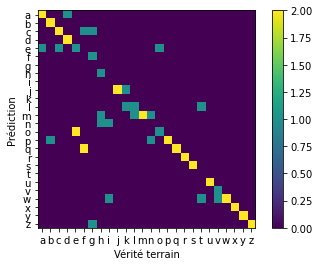

In [179]:
plt.figure()
plt.imshow(conf, interpolation = 'nearest')
plt.colorbar()
plt.xticks(np.arange(26), np.unique(Y))
plt.yticks(np.arange(26), np.unique(Y))
plt.xlabel(u'Vérité terrain')
plt.ylabel(u'Prédiction')
plt.savefig("mat_conf_lettres.png")

**Observations:**

Comme nous nous y attendions, nous obtenons bien une figure avec une diagonale très forte (cette diagonale correspondant aux bonnes classifications).

## E. Modèle génératif

Utiliser les modèles appris pour générer de nouvelles lettres manuscrites.

### E1. Tirage selon une loi de probabilité discrète

- faire la somme cumulée de la loi {$sc$}
- tirer un nombre aléatoire {$t$} entre 0 et 1
- trouver la première valeur de {$sc$} qui est supérieure à {$t$}
- retourner cet état 

**Note :** comme vu en cours, tout repose sur la somme cumulée (notée ici `sc$`, calculable en appelant `np.cumsum`. Sur un exemple: la loi `V = [0.2, 0.4, 0.3, 0.1]` a pour somme cumulée `V.cumsum() == [0.2,  0.6,  0.9,  1.0]`

### E2. Génération d'une séquence de longueur N

- tirer un état {$s_0$} selon Pi
- tant que la longueur n'est pas atteinte :
  - tirer un état {$s_{t+1}$} selon {$A[s_{t}]$} 

In [193]:
def generate(Pi, A, n):
    """ Génère une séquence de longueur N selon Pi et A.
        @param Pi: float array, probabilités initiales pour chaque état
        @param A: float array x array, matrice de transitions
        @param n: int, longueur de la séquence à générer
    """
    # --- Initisalisation de la séquence s
    s = []
    
    # --- Tirage de s0 = s[0] selon Pi
    r = np.random.random()
    sc = np.cumsum(Pi)
    
    i = 0
    while r > sc[i]:
        i += 1
    
    s.append(i-1) # valeur de s[0]
    
    
    # -- Tant que la longueur n'est pas atteinte, tirer un état s_{t+1} selon A[s_t]
    
    while len(s) < n:
        r = np.random.random()
        sc = np.cumsum(A[s[-1]])

        i = 0
        while r > sc[i]:
            i += 1

        s.append(i-1)
    
    return np.array(s)

### E3. Affichage du résultat

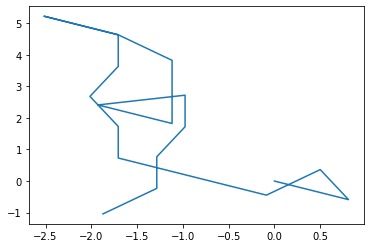

In [227]:
newa = generate(models[0][0], models[0][1], 20)       # generation d'une séquence d'états
intervalle = 360. / d                                 # pour passer des états => valeur d'angles
newa_continu = np.array([i * intervalle for i in newa]) # conv int => double
tracerLettre(newa_continu)

**Observations:**

Hmm... On était censé avoir quelque chose qui ressemble à un 'a' ?